In [1]:
import numpy as np
import mbirjax

# Define parameters for sinogram
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = 'parallel'

# Define projection angles
start_angle = -np.pi / 2
end_angle = np.pi / 2
angles = np.linspace(start_angle, end_angle, num_views)

# Initialize MBIR-JAX model
sinogram_shape = (num_views, num_det_rows, num_det_channels)
ct_model = mbirjax.ParallelBeamModel(sinogram_shape, angles)

# Generate Shepp-Logan phantom
print("Generating Phantom (x)...")
true_image = np.array(ct_model.gen_modified_3d_sl_phantom(), dtype=np.float32)

# Compute forward projection (A*x = y)
print("Computing Sinogram (y = A*x)...")
y = np.array(ct_model.forward_project(true_image), dtype=np.float32)

# Save sinogram and angles in a single .npz file
np.savez("sinogram_data.npz", sinogram=y, angles=angles)

print("Sinogram and angles saved successfully in sinogram_data.npz.")


Estimated memory required = 0.183GB full, 0.012GB update
Using TFRT_CPU_0 for main memory, TFRT_CPU_0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Generating Phantom (x)...
Computing Sinogram (y = A*x)...
Sinogram and angles saved successfully in sinogram_data.npz.


Estimated memory required = 0.183GB full, 0.012GB update
Using TFRT_CPU_0 for main memory, TFRT_CPU_0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Starting MBIR Reconstruction using JAX...
Iteration 0: Loss = 197.092667
Iteration 10: Loss = 135.380585
Iteration 20: Loss = 94.875816
Iteration 30: Loss = 68.171738
Iteration 40: Loss = 50.458588
Iteration 50: Loss = 38.612358
Iteration 60: Loss = 30.602657
Iteration 70: Loss = 25.109329
Iteration 80: Loss = 21.273115
Iteration 90: Loss = 18.534161
Iteration 100: Loss = 16.527035
Iteration 110: Loss = 15.012736
Iteration 120: Loss = 13.834483
Iteration 130: Loss = 12.889012
Iteration 140: Loss = 12.107927
Iteration 150: Loss = 11.445615
Iteration 160: Loss = 10.871367
Iteration 170: Loss = 10.364253
Iteration 180: Loss = 9.909815
Iteration 190: Loss = 9.497839
Iteration 200: Loss = 9.121003
Iteration 210: Loss = 8.773886
Iteration 220: Loss = 8.452359
Iteration 230: Loss = 8.153273
Iteration 240: Loss = 7.874040
Iteration 250:

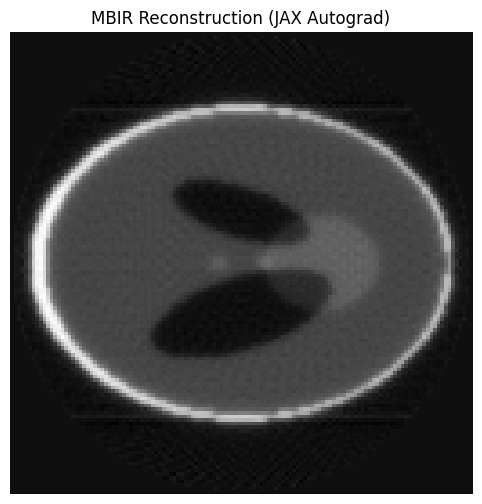

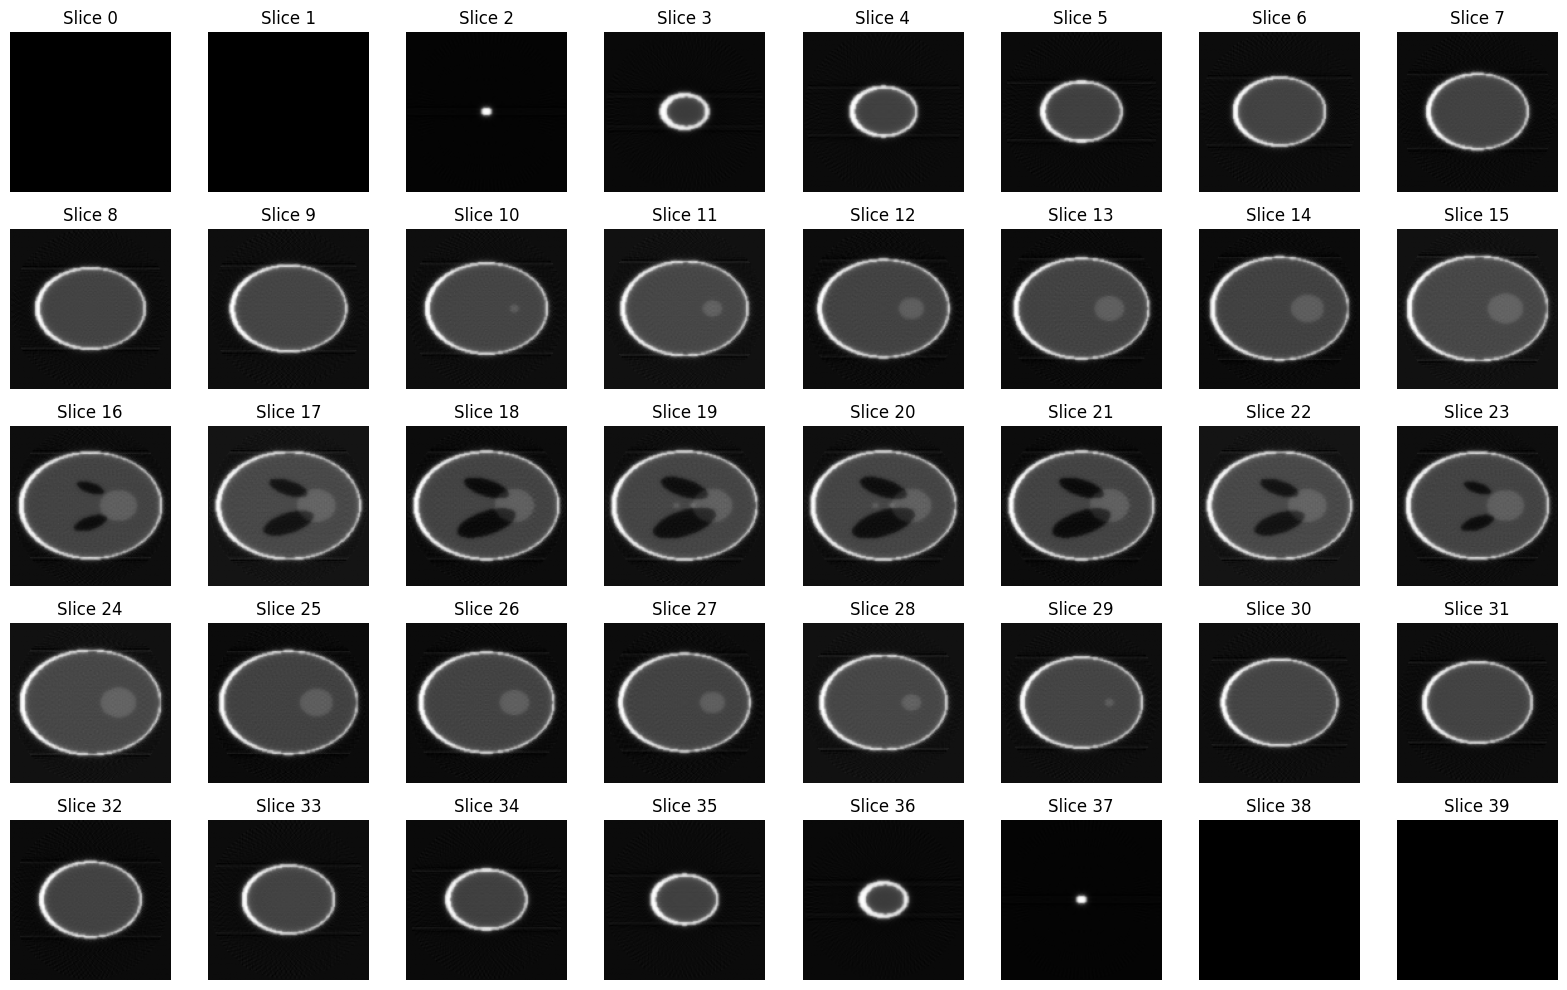

In [5]:
import numpy as np
import jax
import jax.numpy as jnp
import mbirjax
import matplotlib.pyplot as plt

# Load sinogram and angles from single .npz file
data = np.load("sinogram_data.npz")
y = data["sinogram"]
angles = data["angles"]

# Define parameters for reconstruction
num_views, num_det_rows, num_det_channels = y.shape
sinogram_shape = (num_views, num_det_rows, num_det_channels)

# Initialize MBIR-JAX model
ct_model = mbirjax.ParallelBeamModel(sinogram_shape, angles)

# Initialize reconstruction volume
x_init = np.zeros((num_det_channels, num_det_channels, num_det_rows), dtype=np.float32)

# Define loss function
def loss_fn(x):
    Ax = ct_model.forward_project(jnp.asarray(x))  # Ensure input is JAX-compatible
    M = y.size  # Total number of elements in y
    return jnp.sum((y - Ax) ** 2) / M  # Compute normalized loss

# Compute gradient using JAX autograd
grad_loss_fn = jax.grad(loss_fn)

# Gradient descent function
def gradient_descent_step(x, lr):
    grad = grad_loss_fn(x)  # Compute gradient
    return x - lr * grad  # Update step

# Gradient descent parameters
num_iterations = 2000
learning_rate = 0.5
x = x_init  # Initialize x

# Run gradient descent optimization
print("Starting MBIR Reconstruction using JAX...")
for i in range(num_iterations):
    x = gradient_descent_step(x, learning_rate)

    if i % 10 == 0:
        loss = loss_fn(x)
        print(f"Iteration {i}: Loss = {loss:.6f}")

# Convert to NumPy for visualization
mbir_reconstruction = np.array(x)

# Display the reconstruction result
plt.figure(figsize=(12, 6))
plt.imshow(mbir_reconstruction[:, :, mbir_reconstruction.shape[2] // 2], cmap='gray')
plt.title("MBIR Reconstruction (JAX Autograd)")
plt.axis("off")
plt.show()

# Plot all slices for inspection
num_slices = mbir_reconstruction.shape[2]
cols = 8  # Number of columns in the grid
rows = int(np.ceil(num_slices / cols))  # Compute number of rows

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap='gray')
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

# Hide unused subplots
for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()
